# Neural Re-Ranking

Armanni Luca - 509085

Ghiotto Alessandro - 513944

---

This notebook have as main protagonist the following pipeline: `BM25 % k >> BiEncoder`

### Table of contents:
- Bi-encoder and FAISS indexes
  - FAISS 
  - First stage retriever with BM25
  - Second stage retriever with Bi-encoder
- Simple reranking
- Learn to rank


In [1]:
### FOR COLAB

# !pip install -q condacolab
# import condacolab
# condacolab.install()

# !conda install -c pytorch faiss-gpu -y

# !pip install --upgrade -q python-terrier
# !pip install -q sentence_transformers ipdb emoji

# !gdown 1HhgXzyEpsZNcenU9XhJuOYyDUKEzUse4
# !unzip pir_data.zip

In [2]:
import pandas as pd
import re
import os
import shutil
import torch
import numpy as np
import random
from sentence_transformers import SentenceTransformer
import faiss
import time

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# TEXT PROCESSING
from textblob import TextBlob
import emoji
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# TERRIER
from pyterrier.measures import *
import pyterrier as pt

if not pt.java.started():
    pt.utils.set_tqdm('notebook')
    pt.java.init()

# SET SEED
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /home/ghi/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


In [3]:
##### UTILITY function
### DISPLAY STYLED df
# set with colors highest values in each column
def display_styled(df, ignore_cols=[], color="#37614a"):
    """ignore_cols: list of columns to not color"""
    def highlight_max(s):
        if s.name in ignore_cols:  # Skip styling for the 'Name' column
            return ['' for _ in s]
        is_max = s == s.max()
        return [f'font-weight: bold; background-color: {color};' if v else '' for v in is_max]

    styled_df = (
        df.style
        .apply(highlight_max, axis=0)  # Apply styling
        .format({col: "{:.3f}" for col in df.select_dtypes(include='number').columns})  # Format numeric columns only
    )
    display(styled_df)
    return None

In [4]:
stemmer = PorterStemmer()
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def preprocess_text(text, apply_stemmer=False, remove_stopwords=False):
    # remove emojis
    text = emoji.replace_emoji(text, "")
    # remove links
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    # remove html tags
    # text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # lowercase verything
    text = text.lower()
    # remove backslashes
    text = re.sub(r"\\", "", text)
    # remove special characters and punctuation
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # remove whitespaces
    text = re.sub(r"\s+", " ", text)
    # remove leading and trailing whites
    text = text.strip()
    # apply spelling correction
    # text = TextBlob(text).correct()
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    if apply_stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /home/ghi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# COLLECTION OF DOCUMENTS (ANSWERS)
def preprocess_corpus(df):
    df = df.reset_index()
    df.columns = ['docno', 'text']
    df = df.reset_index(drop=True)
    # df['text_stemmed_stopwords_removed'] = df['text'].apply(lambda x: preprocess_text(x, apply_stemmer=True, remove_stopwords=True))
    return df

corpus_df = preprocess_corpus(pd.read_json('PIR_data/answer_retrieval/subset_answers.json', orient='index'))

# SAMPLES (QUERIES)
def preprocess_queries_df(path):
    df = pd.read_json(path, lines=True)
    df = df[['id', 'text']]
    df.columns = ['qid', 'query_unprocessed']
    df['query'] = df['query_unprocessed'].apply(lambda x: preprocess_text(x, apply_stemmer=True, remove_stopwords=True))
    df = df.reset_index(drop=True)
    return df

train_queries = preprocess_queries_df('PIR_data/answer_retrieval/train/subset_data.jsonl')
val_queries = preprocess_queries_df('PIR_data/answer_retrieval/val/subset_data.jsonl')
# test_queries = preprocess_queries_df('PIR_data/answer_retrieval/test/subset_data.jsonl')

# QRELS
def preprocess_qrels_df(path):
    df = pd.read_json(path, orient='index').reset_index()
    df.columns = ['qid', 'docno']
    df['label'] = 1
    df = df.reset_index(drop=True)
    return df

train_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/train/qrels.json')
val_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/val/qrels.json')
# test_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/test/qrels.json')

print("ANSWERS")
display(corpus_df.head(3))
print("QUERIES")
display(train_queries.head(3))
print("QRELS")
display(train_qrels.head(3)) 

ANSWERS


,docno,text
0,writers_2010,TL;DRIf you're going to do present tense do it...
1,writers_2018,"Your writing style is stream-of-consciousness,..."
2,writers_2023,Place emphasis on uncomfortable things. Depend...


QUERIES


,qid,query_unprocessed,query
0,academia_100305,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...
1,academia_100456,Is there a free (as in freedom) alternative to...,free freedom altern publon review journal allo...
2,academia_103390,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...


QRELS


,qid,docno,label
0,academia_100305,academia_100217,1
1,academia_100456,academia_100462,1
2,academia_103390,academia_103391,1


The *'query'* columns contains the old *'text_stemmed_stopwords_removed'*, it is renaimed directly as query so in the first stage retrieval we directly take it as input for BM25 (for compatibility with pyterrier). The *'query_unprocessed'* will be used to get the dense embedding with the BiEncoder, and then do the similarity search with the collection.

---

# Bi-encoder and FAISS indexes

For doing the neural reranking on top of the BM25 model, we have chosen to use the **Bi-encoder** architecture. We find that is better than the cross-encoder, since it is lighter and allows to **precompute the embeddings** of the collection.

First we precompute the two indexes. The sparse one on the preprocesed text for BM25 and a dense one on the unprocessed text for the neural reranker. We store the dense index with **FAISS** ([Manual](https://www.pinecone.io/learn/series/faiss/), [Documentation](https://faiss.ai/), [GitHub](https://github.com/facebookresearch/faiss))

We use ['all-MiniLM-L12-v2'](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2) as BiEncoder. It is trained on StackExchange, so we don't need to fine tune it for our specific dataset

In [6]:
# load the SentenceTransformer model (miniLM)
biencoder_model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

index_path = "./index_sepqa/MiniLM_faiss_IndexFlatIP.index"
if not os.path.exists("./index_sepqa/"):
    os.makedirs("./index_sepqa/", exist_ok=True)

RECREATE_INDEX = False
if RECREATE_INDEX or not os.path.exists(index_path):
    print("Creating a new index...")
    # compute all the embeddings
    corpus_embeddings = biencoder_model.encode(corpus_df['text'].tolist(), show_progress_bar=True)
    print("corpus_embeddings.shape:", corpus_embeddings.shape)
    # corpus_embeddings.shape: (9398, 384) -> (num_docs, embedding_dim)

    # normalize the embeddings
    corpus_embeddings = np.array(corpus_embeddings, dtype='float32')
    corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

    # create a FAISS index for cosine similarity (IP = Inner Product)
    FAISS_INDEX = faiss.IndexFlatIP(corpus_embeddings.shape[1])

    # sdd vectors to the FAISS index
    FAISS_INDEX.add(corpus_embeddings)

    # save the index
    faiss.write_index(FAISS_INDEX, index_path)
else:
    print("Loading the index...")
    FAISS_INDEX = faiss.read_index(index_path)

Loading the index...


### FAISS

here we have an usage example for faiss FlatIndexIP

In [7]:
# load FAISS index
index_path = "./index_sepqa/MiniLM_faiss_IndexFlatIP.index"
FAISS_INDEX = faiss.read_index(index_path)

# generate query embedding
example_query = train_queries.iloc[2]
query_embedding = biencoder_model.encode([example_query['query_unprocessed']])[0].astype('float32')
query_embedding = query_embedding / np.linalg.norm(query_embedding) # normalize for cosine similarity

# Search for the top-k similar documents
# distances = dot produts, indices = document index
# np.array([query_embedding]) -> 2D array, as FAISS expects a batch of queries
k = 5
distances, indices = FAISS_INDEX.search(np.array([query_embedding]), k)

# get the top k docs from the corpus_df
# use indices to get corresponding rows (faiss doesn't store docno, it jsut goes by index)
top_k_docs = corpus_df.iloc[indices[0]].copy()
top_k_docs['similarity'] = distances[0]

print("QUERY:", example_query['query_unprocessed'])
print(f"\n--- TOP-{k} DOCS ---\n")
for i, row in top_k_docs.iterrows():
    print(f"DOCNO={row['docno']} - index={i} - SIMILARITY={row['similarity']:.3f}")
    print(row['text'])
    print()

QUERY: Search for StackExchange citations with Google Scholar Is it possible to use Google Scholar to search for publications that cite StackExchange users, questions, or answers?cf. my Meta StackExchange question "Publications that cite Stack Exchange" or "Academic papers using Stack Exchange data"

--- TOP-5 DOCS ---

DOCNO=academia_103391 - index=9386 - SIMILARITY=0.639
According to this answer to "Publications that cite Stack Exchange":Legally, anyone citing a Stack Exchange post must credit the author's user profile (among other things), which looks something like this:https://site.stackexchange.com/users/#####/usernameA Google Scholar search for "stackexchange.com/users/" yields many results.

DOCNO=academia_76625 - index=9363 - SIMILARITY=0.524
The recipe is this:Sign In to Google Scholar.Click on My Citations.Type your co-author name in the search box provided (top right).You will get a list of authors that match the search. Click on the "Add co-author" button on the right of t

In [8]:
# RETRIEVE ON A SUBSET OF THE COLLECTION
# The subset is specifed by an array of indices

# subset: all documents except for this two, so we see that they are not retrieved
docno_to_remove = ['academia_76625', 'linguistics_25668']
ids_to_remove = corpus_df[corpus_df['docno'].isin(docno_to_remove)].index.values
filter_ids = [i for i in range(len(corpus_df)) if i not in ids_to_remove]

# IDSelectorArray : specify the elements to pipck up from the index and compare with the query
id_selector = faiss.IDSelectorArray(filter_ids)

# put the selector in the search parameters
search_params = faiss.SearchParametersIVF(sel=id_selector)

filtered_distances, filtered_indices = FAISS_INDEX.search(np.array([query_embedding]), k, params=search_params)

# retrieve metadata for the top-k documents
# use indices to get corresponding rows (faiss doesn't store docno, it jsut goes by index)
top_k_docs = corpus_df.iloc[filtered_indices[0]].copy()
top_k_docs['similarity'] = filtered_distances[0]

print("QUERY:", example_query['query_unprocessed'])
print(f"\n--- TOP-{k} DOCS without {docno_to_remove}---\n")
for i, row in top_k_docs.iterrows():
    print(f"DOCNO={row['docno']} - index={i} - SIMILARITY={row['similarity']:.3f}")
    print(row['text'])
    print()

QUERY: Search for StackExchange citations with Google Scholar Is it possible to use Google Scholar to search for publications that cite StackExchange users, questions, or answers?cf. my Meta StackExchange question "Publications that cite Stack Exchange" or "Academic papers using Stack Exchange data"

--- TOP-5 DOCS without ['academia_76625', 'linguistics_25668']---

DOCNO=academia_103391 - index=9386 - SIMILARITY=0.639
According to this answer to "Publications that cite Stack Exchange":Legally, anyone citing a Stack Exchange post must credit the author's user profile (among other things), which looks something like this:https://site.stackexchange.com/users/#####/usernameA Google Scholar search for "stackexchange.com/users/" yields many results.

DOCNO=academia_864 - index=9213 - SIMILARITY=0.492
I've had great experience with Google Scholar Alerts. To use them, go to scholar.google.com and search for any term. In the results page, you will see a link to Create Email Alert. Click on tha

### First stage retriever with BM25

We will use the parameters that got the best results on the recall : `{'c': 1.0, 'bm25.k_1': 2.5}`

We have recreated it instead of reusing the one from the previous notebook. because in the previous notebook we have removed documents that becames empty after the preprocessing, now we replace them with a placeholder, so we don't get a mismatch in the docid between the index of bm25 and the dense one in faiss.

In [9]:
# path to the the index for BM25
path = "./index_sepqa/index_bm25/"

RECREATE_INDEX = False
if RECREATE_INDEX or not os.path.exists(path+"data.properties"):
    corpus_df_indexing = corpus_df.copy()
    corpus_df_indexing['text'] = corpus_df_indexing['text'].apply(lambda x: preprocess_text(x, apply_stemmer=True, remove_stopwords=True))
    # put a placeholder for empty documents. so the number docid is consistent
    # If I delete them, I will get n docs in the dense index and n-(empty_docs) in the BM25 index
    # use 'the' as a placeholder so I'm sure to get 0 similarity (the other docs have no stopwords)
    corpus_df_indexing['text'] = corpus_df_indexing['text'].replace('', 'the')
    max_text = corpus_df_indexing['text'].apply(len).max()
    max_docno = corpus_df_indexing['docno'].apply(len).max()

    if os.path.exists(path):
        shutil.rmtree(path)

    indexer = pt.IterDictIndexer(path, stemmer=None, stopwords=None)
    indexer.index(
        corpus_df_indexing.to_dict(orient='records'),
        fields={'text': max_text}, 
        meta={'docno': max_docno},
    )

path =  path+"data.properties"
bm25_index = pt.IndexFactory.of("./index_sepqa/index_bm25/data.properties")

bm25 = pt.terrier.Retriever(
    bm25_index, 
    wmodel="BM25", 
    controls={'c': 1.0, 'bm25.k_1': 2.5},
    properties={"termpipelines": ""},
) % 100 # returns only the top 100 ranked tocs


### Second stage retriever with Bi-encoder

Now we write the function that given as input the queries, search in the FAISS index the closest docs (closest in cosine similarity) and returns the top k docs and the corresponding score. If the dense retriever will receive as input already some retrieved documents, it will just rerank them.

About `IDSelectorArray`: the ids are just provided and stored as an array. For IndexFlat, it simply picks up the database elements to compare with, which is perfect for implementing reranking.

In [10]:
# load FAISS index
index_path = "./index_sepqa/MiniLM_faiss_IndexFlatIP.index"
FAISS_INDEX = faiss.read_index(index_path)

def get_dense_scores_VERBOSE(df):
    """
    get cosine similarity score with a biencoder model, with FAISS FlatIndex

    used as argument of pyterrier.apply.doc_score()
        =>  the input is a ranked documents dataframe (batch), by query
            the output are the scores for each document in the batch
    """
    # get the qid of the batch
    qid = df['qid'].iloc[0] 
    if not all(df['qid'] == qid):
        assert "Not all qids in the batch are equal"

    # get the query unprocessed text
    query_text = df['query_unprocessed'].iloc[0]
    # get the query embedding
    query_embedding = biencoder_model.encode(query_text).astype('float32')
    query_embedding = query_embedding / np.linalg.norm(query_embedding) # normalize for cosine similarity

    print("\n"+"-"*50+f"\nINPUT QUERY ID = {qid}:\n")
    print(f"QUERY TEXT: {query_text}")
    print("QUERY EMBEDDING.SHAPE:", query_embedding.shape)

    # if we are using the dense retriever after BM25:
    # we search only betweeen the already retrieved documents
    if 'docid' in df.columns:
        # select the retrieved documents
        filter_ids = df['docid'].values
        id_selector = faiss.IDSelectorArray(np.array(filter_ids, dtype=np.int64))
        search_params = faiss.SearchParametersIVF(sel=id_selector)
        
        k = len(filter_ids) # rerank the already retrieved documents
        distances, indices = FAISS_INDEX.search(np.array([query_embedding]), k, params=search_params)

        print(f"FILTER ID (ids received for qid={qid}): {filter_ids[:10]} ...")
        intersection_indices = np.intersect1d(indices[0], filter_ids)
        if len(intersection_indices) != len(filter_ids):
            assert "Output indices are not the same as the input docids"
    
    # if we are using the dense retriever from scratch
    # we search between all the documents
    else:
        k = 1000 # retrieve top 1000 documents (default also in pyterrier)
        distances, indices = FAISS_INDEX.search(np.array([query_embedding]), k)

    # distances : are the scores
    # indices : are the docids of the in the reraanked order
    # mapping {docid: score}
    score_mapping = {docid: score for docid, score in zip(indices[0], distances[0])}

    # I want to supply the scores in the original order
    # so they replace the scores from BM25 (or they can be just concatenated/added...)
    scores_original_order = [score_mapping[docid] for docid in df['docid']]
    print("BM25 SCORES  :", df['score'].round(3).values[:10])
    print("DENSE SCORES :", [round(score, 3) for score in scores_original_order[:10]])
    return scores_original_order

reranking = pt.apply.doc_score(get_dense_scores_VERBOSE, batch_size=64)

# Combine the pipelines
pipeline = bm25 >> reranking

In [11]:
### EXAMPLE : HOW DOES IT WORKS

example_query = train_queries.head(3)
example_qrels = train_qrels[train_qrels['qid'].isin(example_query['qid'])]
#example_query = example_query[['qid', 'query_text_stemmed_stopwords_removed']]
print("QUERY:")
print(f"shape={example_query.shape}, number of rows {example_query.shape[0]} is the number of queries")
display(example_query)

bm_results = bm25.transform(example_query)
print("=================      FEED IT TO BM25       =================\n")
print("BM25 RESULTS:")
print(f"shape={bm_results.shape}, number of rows {bm_results.shape[0]} is the number of queries * 100, which is the cutoff %")
display(bm_results)

print("================= FEED IT TO NEURAL RERANKER =================\n")
print("RERANKING....")
faiss_results = reranking.transform(bm_results)
print("\nRERANKED RESULTS:")
display(faiss_results)

QUERY:
shape=(3, 3), number of rows 3 is the number of queries


,qid,query_unprocessed,query
0,academia_100305,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...
1,academia_100456,Is there a free (as in freedom) alternative to...,free freedom altern publon review journal allo...
2,academia_103390,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...


=================      FEED IT TO BM25       =================

BM25 RESULTS:
shape=(300, 7), number of rows 300 is the number of queries * 100, which is the cutoff %


,qid,docid,docno,rank,score,query_unprocessed,query
0,academia_100305,9384,academia_100217,0,53.054090,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...
1,academia_100305,9352,academia_66397,1,22.017344,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...
2,academia_100305,9366,academia_78680,2,20.022814,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...
3,academia_100305,9296,academia_28963,3,19.258206,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...
4,academia_100305,9331,academia_43963,4,17.759112,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...
...,...,...,...,...,...,...,...
295,academia_103390,409,travel_3388,95,11.926433,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...
296,academia_103390,687,travel_117087,96,11.899063,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...
297,academia_103390,2107,politics_1165,97,11.859220,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...
298,academia_103390,5390,hinduism_792,98,11.814111,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...


================= FEED IT TO NEURAL RERANKER =================

RERANKING....

--------------------------------------------------
INPUT QUERY ID = academia_100305:

QUERY TEXT: What are CNRS research units and how are they staffed The Centre national de la recherche scientifique (CNRS) is the major funding body in France. With nearly 32,000 staff members it is bigger than the US NIH and US NSF combined, yet only has a 1/10 of the budget.Both CNRS and NIH have multiple institutes (although the NIH institutes are all health related and CNRS covers a range of science). The CNRS then has 952 mixed research units, 32 proper research units, 135 service units, as well as 36 international units while the NIH has a large number of intramural labs.What are these different research units and how are they staffed (full time researchers or academics with other teaching duties)? Is it at all like NIH intramural labs or MRC centres?
QUERY EMBEDDING.SHAPE: (384,)
FILTER ID (ids received for qid=academ

,qid,docid,docno,score,query_unprocessed,query,rank
0,academia_100305,9384,academia_100217,0.805529,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...,0
1,academia_100305,9352,academia_66397,0.143322,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...,34
2,academia_100305,9366,academia_78680,0.205681,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...,17
3,academia_100305,9296,academia_28963,0.128185,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...,38
4,academia_100305,9331,academia_43963,0.182469,What are CNRS research units and how are they ...,cnr research unit staf centr nation de la rech...,24
...,...,...,...,...,...,...,...
295,academia_103390,409,travel_3388,0.141091,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...,28
296,academia_103390,687,travel_117087,-0.023673,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...,89
297,academia_103390,2107,politics_1165,0.173143,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...,18
298,academia_103390,5390,hinduism_792,0.134225,Search for StackExchange citations with Google...,search stackexchang citat googl scholar possib...,32


In [12]:
# Experiment(.) = Evalutae(Transform(.))
print("EVALUATING THE TRANSFORMED OUTPUTS:\n")
eval_bm25 = pt.Evaluate(bm_results, example_qrels, metrics=[P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100])
print("EVALUATE ON BM25 OUTPUT:")
print(eval_bm25)
print()
eval_faiss = pt.Evaluate(faiss_results, example_qrels, metrics=[P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100])
print("EVALUATE ON RERANKED OUTPUT:")
print(eval_faiss)

EVALUATING THE TRANSFORMED OUTPUTS:

EVALUATE ON BM25 OUTPUT:
{'P@1': 1.0, 'P@3': 0.3333333333333333, 'nDCG@3': 1.0, 'nDCG@10': 1.0, 'R@100': 1.0, 'AP@100': 1.0}

EVALUATE ON RERANKED OUTPUT:
{'P@1': 1.0, 'P@3': 0.3333333333333333, 'nDCG@3': 1.0, 'nDCG@10': 1.0, 'R@100': 1.0, 'AP@100': 1.0}


---

# Simple reranking

After seeing how FAISS works we implement a simple reranking pipeline and see the results for different cutoffs k in [15, 30, 50, 100, 200]. Now we jsut take as output only the score given by the neural retriever.

`PIPELINE = BM25 % k >> BiEncoder`

$\text{final\_score = BiEncoder\_score}$ 

In [13]:
from functools import partial

### REWRITE THE FUNCTION WITHOUT PRINTS

def _get_dense_scores(df, FAISS_INDEX, biencoder_model, text_field='query_unprocessed', k=1000):
    """
    get cosine similarity score with a biencoder model, with FAISS FlatIndex

    used as argument of pyterrier.apply.doc_score()
        =>  the input is a ranked documents dataframe (batch), by query
            the output are the scores for each document in the batch
    """
    if not all(df['qid'] == df['qid'].iloc[0]):
        assert "Not all qids in the batch are equal"
    # get the query unprocessed text
    query_text = df[text_field].iloc[0]
    # get the query embedding
    query_embedding = biencoder_model.encode(query_text).astype('float32')
    query_embedding = query_embedding / np.linalg.norm(query_embedding) # normalize for cosine similarity

    # if we are reranking
    if 'docid' in df.columns:
        # select the retrieved documents
        filter_ids = df['docid'].values
        id_selector = faiss.IDSelectorArray(np.array(filter_ids, dtype=np.int64))
        search_params = faiss.SearchParametersIVF(sel=id_selector)
        # rerank them
        k = len(filter_ids)
        distances, indices = FAISS_INDEX.search(np.array([query_embedding]), k, params=search_params)
    else:
        distances, indices = FAISS_INDEX.search(np.array([query_embedding]), k)

    # mapping {docid: score}
    score_mapping = {docid: score for docid, score in zip(indices[0], distances[0])}
    # get the scores in the original order (same as the input docids)
    scores_original_order = [score_mapping[docid] for docid in df['docid']]
    return scores_original_order

In [14]:
### FIRST STAGE
path = "./index_sepqa/index_bm25/data.properties"
bm25_index = pt.IndexFactory.of(path)

bm25 = pt.terrier.Retriever(
    bm25_index, 
    wmodel="BM25", 
    controls={'c': 1.0, 'bm25.k_1': 2.5},
    properties={"termpipelines": ""},
)

### SECOND STAGE
index_path = "./index_sepqa/MiniLM_faiss_IndexFlatIP.index"
FAISS_INDEX = faiss.read_index(index_path)

# set the current FAISS index and biencoder model
get_dense_score = partial(_get_dense_scores, FAISS_INDEX=FAISS_INDEX, biencoder_model=biencoder_model)
reranker = pt.apply.doc_score(get_dense_score, batch_size=64)

NOTES:

- `precompute_prefix=True` : will precompute the results of the common initial stages, and then use these results to call the subsequent remainder of each pipelines. This allows us to execute the bm25 transformer only once on the input queries, and then reuse those results as input to the biencoder.
- `save_mode` :  Defines how existing files are used when save_dir is set. If set to “reuse”, then files will be preferred over transformers for evaluation. If set to “overwrite”, existing files will be replaced. If set to “warn” or “error”, the presence of any existing file will cause a warning or error, respectively. Default is “warn”.

In [15]:
########## EXPERIMENT ##########
# set trehsolds cutoffs k
tresholds_k = [15, 30, 50, 100, 200]
# create a pipeline for each threshold
pipelines = [bm25 % k >> reranker for k in tresholds_k]
pipelines = [bm25] + pipelines
# get the corresponding names
names = [f"BM25@{k}_MiniLM" for k in tresholds_k]
names = ["BM25"] + names
# evaluation metrics
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
# save the results
save_dir = "./experiments/reranking/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

SAVE_MODE = "reuse" # reuse warn overwrite error

# run the experiment
t0 = time.time()
results = pt.Experiment(
    pipelines,
    train_queries,
    train_qrels,
    eval_metrics=metrics,
    names=names,
    save_dir=save_dir,
    save_mode=SAVE_MODE,
    precompute_prefix=True if SAVE_MODE != "reuse" else False,
)

path = "./experiments/reranking/results_BM25@k_MiniLM.csv"
if SAVE_MODE == "overwrite" or not os.path.exists(path):
    print("Experiment duration :", round(time.time()-t0, 2), "seconds")
    # Experiment duration : 404.67 seconds
    results.to_csv(path)

display_styled(results, ignore_cols=['name', 'mrt'])

,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,BM25,0.701,0.271,0.767,0.793,0.946,0.767,0.000
1,BM25@15_MiniLM,0.268,0.141,0.357,0.478,0.898,0.402,0.000
2,BM25@30_MiniLM,0.436,0.177,0.492,0.549,0.919,0.518,0.000
3,BM25@50_MiniLM,0.429,0.170,0.476,0.521,0.932,0.499,0.000
4,BM25@100_MiniLM,0.820,0.300,0.868,0.879,0.946,0.863,0.000
5,BM25@200_MiniLM,0.825,0.302,0.874,0.885,0.956,0.869,0.000


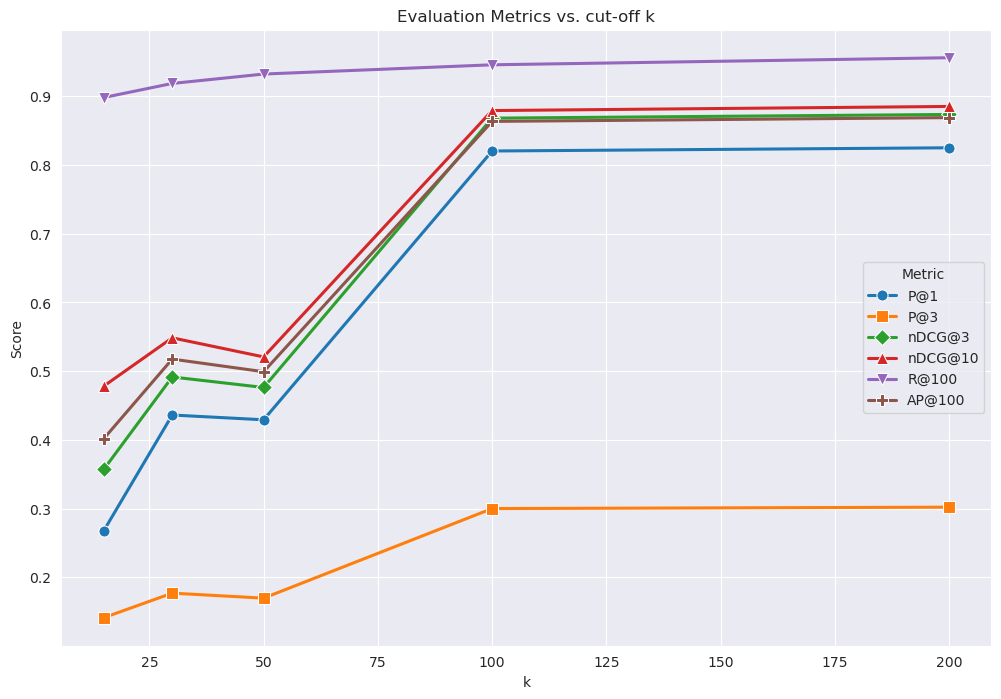

In [16]:
# Extract the values for the x-axis (thresholds k) and y-axis (evaluation metrics)
x = tresholds_k
y_p1 = results.loc[1:, 'P@1'].values
y_p3 = results.loc[1:, 'P@3'].values
y_ndcg3 = results.loc[1:, 'nDCG@3'].values
y_ndcg10 = results.loc[1:, 'nDCG@10'].values
y_r100 = results.loc[1:, 'R@100'].values
y_ap100 = results.loc[1:, 'AP@100'].values

data = pd.DataFrame({
    'k': x,
    'P@1': y_p1,
    'P@3': y_p3,
    'nDCG@3': y_ndcg3,
    'nDCG@10': y_ndcg10,
    'R@100': y_r100,
    'AP@100': y_ap100
})

# Melt the DataFrame to long-form for Seaborn
data_melted = data.melt('k', var_name='Metric', value_name='Score')

# Define markers for each metric
markers = {'P@1': 'o', 'P@3': 's', 'nDCG@3': 'D', 'nDCG@10': '^', 'R@100': 'v', 'AP@100': 'P'}

# Plot the data
plt.figure(figsize=(12, 8))
sns.lineplot(data=data_melted, x='k', y='Score', hue='Metric', style='Metric', markers=markers, dashes=False, linewidth=2.2, markersize=8)

# Add labels and title
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs. cut-off k')
plt.grid(True)
plt.show()

The best treshold is given by **k = 100**. the difference with k = 50 is huge, and if we go to k = 200 we don't gain anything.

In [15]:
### Results on the validation set

pipeline_100 = bm25 % 100 >> reranker

metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']

results_val = pt.Experiment(
    [pipeline_100],
    val_queries,
    val_qrels,
    eval_metrics=metrics,
    names=['val_BM25@100_MiniLM'],
    save_dir="./experiments/reranking/",
    save_mode="reuse", # reuse warn overwrite
)

path = "./experiments/reranking/val_BM25@100_MiniLM.csv"
results_val.to_csv(path)

display(results_val.round(3))

,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,val_BM25@100_MiniLM,0.908,0.31,0.921,0.938,0.969,0.927,0.0


---

# Learn to rank

Instead of just keeping the score given by the neural model, we can take it and combine it with the score given by BM25. For example we can take a weighted average between the two. We train a logistic regression classifier that takes as input the 2 scores and returns our output score.

`PIPELINE = BM25 % 100 >> (Norm_BM25 ** Norm_BiEncoder) >> pt.ltr.apply_learned_model(LogisticRegression)`

$\text{final\_score} = \sigma(\lambda_1 \cdot \text{BM25\_score} + \lambda_2 \cdot \text{BiEncoder\_score} + \text{c})$ 

- since we have seen that a treshold higher than 100 doesn't increase the Recall@k measure, we will still use BM25 as a first stage retriever.

- the  BM25 score and the BiEncoder score will be normalized before of being passed to the classifier


In [16]:
### BM25
path = "./index_sepqa/index_bm25/data.properties"
bm25_index = pt.IndexFactory.of(path)
bm25 = pt.terrier.Retriever(bm25_index, wmodel="BM25", controls={'c': 1.0, 'bm25.k_1': 2.5},properties={"termpipelines": ""})
# normalize the BM25 scores
norm_bm25 = bm25 >> pt.pipelines.PerQueryMaxMinScoreTransformer()

### BI-ENCODER
index_path = "./index_sepqa/MiniLM_faiss_IndexFlatIP.index"
FAISS_INDEX = faiss.read_index(index_path)
get_dense_score = partial(_get_dense_scores, FAISS_INDEX=FAISS_INDEX, biencoder_model=biencoder_model)
bi_enc = pt.apply.doc_score(get_dense_score, batch_size=64)
# normalize the bi-encoder scores
norm_bi_enc = bi_enc >> pt.pipelines.PerQueryMaxMinScoreTransformer()

### RERANKING + GET OUTPUT FEATURES
# ** : concatenate the scores and save them as 'features'
# so we take as input only the candidates given by BM25
# then take as features the scores from the bi-encoder and BM25
pipeline = bm25 % 100 >> (norm_bm25 ** norm_bi_enc)


####### EXAMPLE OUTPUT FEATURES #######
sample = train_queries.head(3)
candidates = (bm25 % 100).transform(sample)

out_norm_bm25 = norm_bm25.transform(candidates)
print(f"BM25 NORMALIZED OUTPUT SCORES:\n{out_norm_bm25['score'].iloc[:5]} ...")

out_norm_bi_enc = norm_bi_enc.transform(candidates)
print(f"\nBI-ENCODER OUTPUT SCORES:\n{out_norm_bi_enc['score'].iloc[:5]} ...")

output = pipeline.transform(sample)
print(f"\nPIPELILE OUTPUT FEATURES:\n{output['features'].iloc[:5]} ...")

BM25 NORMALIZED OUTPUT SCORES:
0    1.000000
1    0.262779
2    0.215403
3    0.197241
4    0.161633
Name: score, dtype: float64 ...

BI-ENCODER OUTPUT SCORES:
0    1.000000
1    0.211974
2    0.286181
3    0.193961
4    0.258560
Name: score, dtype: float64 ...

PIPELILE OUTPUT FEATURES:
0                     [1.0, 0.9999999999999999]
1     [0.2627792114793959, 0.21197429237745502]
2     [0.21540281801674488, 0.2861812121793851]
3     [0.19724096263179403, 0.1939605184685119]
4    [0.16163274407746858, 0.25855952120307524]
Name: features, dtype: object ...


We can see that this features are the result of concatenating the two score. This features will be the input of the Logistic Regression model.

We create a Wrapper for the model, that use the `predict_proba()` method when `predict()` is called. So we get an actual score, instead of just 0 or 1.

In [18]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from joblib import dump, load

class PredictProbaWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        # Use the probabilities for the positive class (class 1)
        return self.model.predict_proba(X)[:, 1]

logistic_regressor = LogisticRegression(random_state=seed, max_iter=100) 
logistic_regressor_proba = PredictProbaWrapper(logistic_regressor)
logistic_regressor_pipeline_proba = pipeline >> pt.ltr.apply_learned_model(logistic_regressor_proba)

In [19]:
### FIT THE MODEL
if not os.path.exists("./models"):
    os.makedirs("./models", exist_ok=True)
model_path = "./models/BM25_MiniLM_LR.joblib"
FIT = False

if FIT or not os.path.exists(model_path):
    print("Fitting the model...")
    t0 = time.time()
    logistic_regressor_pipeline_proba.fit(train_queries, train_qrels, val_queries, val_qrels)
    print("Fitting the model took:", round(time.time()-t0), "seconds")
    ### Fitting the model took: 661 seconds

    # save the model
    dump(logistic_regressor_proba, model_path)
    print("Model saved to disk.")
else:
    print("Loading the model from disk...")
    logistic_regressor_proba = load(model_path)
    logistic_regressor_pipeline_proba = pipeline >> pt.ltr.apply_learned_model(logistic_regressor_proba)

print("Model intercept:", logistic_regressor_proba.model.intercept_)
print("Model coefficients:", logistic_regressor_proba.model.coef_)

Loading the model from disk...
Model intercept: [-19.81222206]
Model coefficients: [[ 4.73471037 17.2238749 ]]


input features = [norm_bm25, norm_bi_enc]

$\text{output\_score} = \sigma(4.73 \cdot \text{BM25\_score} + 17.22 \cdot \text{BiEncoder\_score} - 19.81)$ 

Now we can run the experiment on train and val, so we can see if there is overfitting.

In [21]:
# put it just for seeing all of them here
bi_enc_100 = bm25 % 100 >> bi_enc
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
save_dir = "./experiments/reranking/"

SAVE_MODE = "reuse" # reuse warn overwrite error

t0 = time.time()
results = pt.Experiment(
    [bm25, bi_enc_100, logistic_regressor_pipeline_proba],
    train_queries,
    train_qrels,
    eval_metrics=metrics,
    names=["train_BM25", "train_BM25@100_MiniLM", "train_BM25_MiniLM_LR"],
    save_dir=save_dir,
    save_mode=SAVE_MODE,
    precompute_prefix=True if SAVE_MODE != "reuse" else False,
)

path = "./experiments/reranking/results_train_BM25_MiniLM_LR.csv"
if SAVE_MODE == "overwrite" or not os.path.exists(path):
    print("Experiment duration :", round(time.time()-t0, 2), "seconds")
    # Experiment duration : 875.5 seconds
    results.to_csv(path)

display_styled(results, ignore_cols=['name', 'mrt'])

,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,train_BM25,0.701,0.271,0.767,0.793,0.946,0.767,0.000
1,train_BM25@100_MiniLM,0.820,0.300,0.868,0.879,0.946,0.863,0.000
2,train_BM25_MiniLM_LR,0.845,0.305,0.887,0.896,0.946,0.882,0.000


In [22]:
# put it just for the seeing all of them here
bi_enc_100 = bm25 % 100 >> bi_enc
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
save_dir = "./experiments/reranking/"

t0 = time.time()
results = pt.Experiment(
    [bm25, bi_enc_100, logistic_regressor_pipeline_proba],
    val_queries,
    val_qrels,
    eval_metrics=metrics,
    names=["val_BM25", "val_BM25@100_MiniLM", "val_BM25_MiniLM_LR"],
    save_dir=save_dir,
    save_mode="overwrite", # reuse warn overwrite error
    precompute_prefix=True,
)
print("Experiment duration :", round(time.time()-t0, 2), "seconds")

path = "./experiments/reranking/results_val_BM25_MiniLM_LR.csv"
results.to_csv(path)

display_styled(results, ignore_cols=['name', 'mrt'])

Precomputing results of 100 topics on shared pipeline component TerrierRetr(BM25)


Experiment duration : 4.61 seconds


,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,val_BM25,0.755,0.286,0.814,0.841,0.969,0.815,15.453
1,val_BM25@100_MiniLM,0.908,0.310,0.921,0.938,0.969,0.927,22.699
2,val_BM25_MiniLM_LR,0.908,0.313,0.927,0.939,0.969,0.929,30.159


In [23]:
### EXAMPLE OUTPUT SCORES OF THE COMPLETE PIPELINE
pieline_output = pipeline.transform(sample)
print(f"\nPIPELILE OUTPUT FEATURES:\n{pieline_output['features'].iloc[:5]} ...")

output_proba = logistic_regressor_pipeline_proba.transform(sample)
print(f"\nLOGISTIC REGRESSION OUTPUT PROBABILITIES (SCORES):\n{output_proba['score'].iloc[:5]} ...")


PIPELILE OUTPUT FEATURES:
0                     [1.0, 0.9999999999999999]
1     [0.2627792114793959, 0.21197429237745502]
2     [0.21540281801674488, 0.2861812121793851]
3     [0.19724096263179403, 0.1939605184685119]
4    [0.16163274407746858, 0.25855952120307524]
Name: features, dtype: object ...

LOGISTIC REGRESSION OUTPUT PROBABILITIES (SCORES):
0    8.953284e-01
1    3.323689e-07
2    9.534263e-07
3    1.786939e-07
4    4.593096e-07
Name: score, dtype: float64 ...


We can also manually combine with a weighted average the scores of BM25 and the BiEncoder.

`PIPELINE = BM25 % 100 >> l*norm_bm25 + (1-l)*norm_bi_enc`

$\text{final\_score} = \lambda \cdot \text{BM25\_score} + (1 - \lambda) \cdot \text{BiEncoder\_score}$

$for \lambda \in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]$

In [24]:
### COEFFICIENTS
lambdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# create a pipeline for each lambda
pipelines = [bm25 % 100 >> l*norm_bm25 + (1-l)*norm_bi_enc for l in lambdas]

lambdas_str = [f"{v:.1f}".lstrip("0") for v in lambdas]
names = [f"{lambdas_str[i]}*BM25@100_{lambdas_str[-i-1]}*MiniLM" for i in range(len(lambdas_str))]
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
save_dir = "./experiments/reranking/"

t0 = time.time()
results = pt.Experiment(
    pipelines,
    val_queries,
    val_qrels,
    eval_metrics=metrics,
    names=names,
    save_dir=save_dir,
    save_mode="overwrite", # reuse warn overwrite error
    precompute_prefix=True,
)
print("Experiment duration :", round(time.time()-t0, 2), "seconds")

path = "./experiments/reranking/results_val_interpolate_BM25_MiniLM.csv"
results.to_csv(path)

display_styled(results, ignore_cols=['name', 'mrt'])

Precomputing results of 100 topics on shared pipeline component TerrierRetr(BM25)


Experiment duration : 15.05 seconds


,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,.0*BM25@100_1.0*MiniLM,0.908,0.310,0.921,0.938,0.969,0.927,26.549
1,.1*BM25@100_.9*MiniLM,0.918,0.316,0.935,0.943,0.969,0.934,26.527
2,.2*BM25@100_.8*MiniLM,0.908,0.313,0.926,0.938,0.969,0.928,26.972
3,.3*BM25@100_.7*MiniLM,0.908,0.313,0.927,0.937,0.969,0.928,26.590
4,.4*BM25@100_.6*MiniLM,0.888,0.313,0.920,0.923,0.969,0.916,26.844
5,.5*BM25@100_.5*MiniLM,0.888,0.313,0.919,0.925,0.969,0.915,27.952
6,.6*BM25@100_.4*MiniLM,0.857,0.313,0.907,0.913,0.969,0.899,26.270
7,.7*BM25@100_.3*MiniLM,0.837,0.310,0.889,0.900,0.969,0.881,26.786
8,.8*BM25@100_.2*MiniLM,0.796,0.299,0.856,0.877,0.969,0.854,26.757
9,.9*BM25@100_.1*MiniLM,0.755,0.286,0.817,0.851,0.969,0.823,27.271


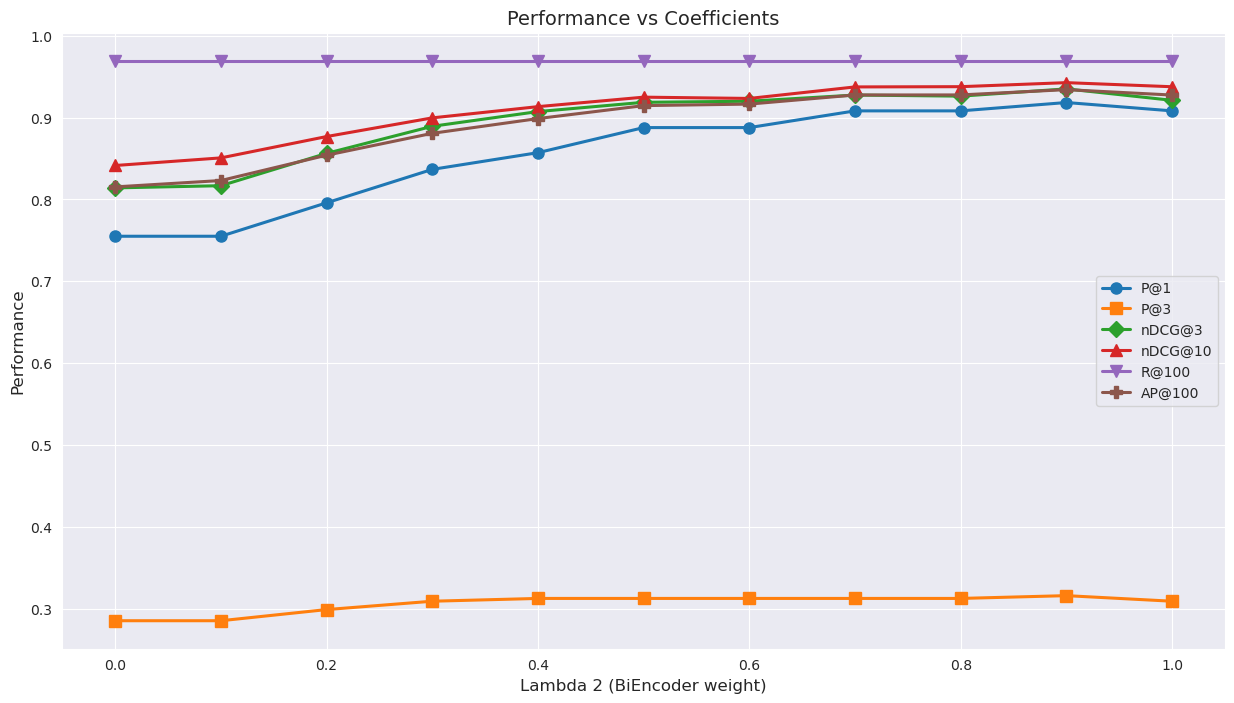

In [25]:
plot_df = results.copy()

# Extract coefficients using regex from the name
# format of the name : lambda1*BM25@100_lambda2*MiniLM
plot_df['lambda1'] = plot_df['name'].str.extract(r'([\d.]+)\*BM25@100')
plot_df['lambda2'] = plot_df['name'].str.extract(r'([\d.]+)\*MiniLM')

# Convert coefficients to float
plot_df['lambda1'] = plot_df['lambda1'].astype(float)
plot_df['lambda2'] = plot_df['lambda2'].astype(float)

# Plot
measures_to_plot = ["P@1", "P@3", "nDCG@3", "nDCG@10", "R@100", "AP@100"]

plt.figure(figsize=(15, 8))
# Define markers for each metric
markers = {'P@1': 'o', 'P@3': 's', 'nDCG@3': 'D', 'nDCG@10': '^', 'R@100': 'v', 'AP@100': 'P'}
for measure in measures_to_plot:
    plt.plot(plot_df["lambda2"], plot_df[measure], label=measure, marker=markers[measure], linewidth=2.2, markersize=8)

plt.title("Performance vs Coefficients", fontsize=14)
plt.xlabel("Lambda 2 (BiEncoder weight)", fontsize=12)
plt.ylabel("Performance", fontsize=12)
plt.legend()
plt.show()


The results of the simple reranking pipeline (`bm25 % 100 >> bi_encoder`) are already high, and we don't gain much in P@1 and P@3 by linearly combining the two scores. But what we get is a more consistent ranking in general, which can be seen more from the nDCG@10 and AP@100 metrics.

### Add TF-IDF score as feature

We can try to add also the TF-IDF score and see if we can get something more from combining such score with our classifier. 

We also try to take the union of the top 100 retrieved docs between TF-IDF and BM25, for seeing if TF-IDF help us to retrieve the last few docs that are not recalled@100 by BM25.

`PIPELINE = (BM25 % 100) | (TFIDF % 100) >> (Norm_BM25 ** Norm_TFIDF ** Norm_BiEncoder)`

$\text{final\_score} = \sigma(\lambda_1 \cdot \text{BM25\_score} + \lambda_2 \cdot \text{TFIDF\_score} + \lambda_3 \cdot \text{BiEncoder\_score} + \text{c})$ 

In [26]:
### SPARSE RETRIEVERS (BM25, TF-IDF)
path = "./index_sepqa/index_bm25/data.properties"
sparse_index = pt.IndexFactory.of(path)
bm25 = pt.terrier.Retriever(sparse_index, wmodel="BM25", controls={'c': 1.0, 'bm25.k_1': 2.5},properties={"termpipelines": ""})
norm_bm25 = bm25 >> pt.pipelines.PerQueryMaxMinScoreTransformer()
tfidf = pt.terrier.Retriever(sparse_index, wmodel="TF_IDF", properties={"termpipelines": ""})
norm_tfidf = tfidf >> pt.pipelines.PerQueryMaxMinScoreTransformer()

# Set union between the retrieved documents from BM25 and TF-IDF
candidates = (bm25 % 100) | (tfidf % 100)

### BI-ENCODER
index_path = "./index_sepqa/MiniLM_faiss_IndexFlatIP.index"
FAISS_INDEX = faiss.read_index(index_path)
get_dense_score = partial(_get_dense_scores, FAISS_INDEX=FAISS_INDEX, biencoder_model=biencoder_model)
bi_enc = pt.apply.doc_score(get_dense_score, batch_size=64)
norm_bi_enc = bi_enc >> pt.pipelines.PerQueryMaxMinScoreTransformer()

### PIPELINE
pipeline = candidates >> (norm_bm25 ** norm_tfidf ** norm_bi_enc)

### ADD A LEARNED MODEL
# again we use the wrapper for predicting probabilities
logistic_regressor = LogisticRegression(random_state=seed, max_iter=100) 
logistic_regressor_proba = PredictProbaWrapper(logistic_regressor)
logistic_regressor_pipeline_proba = pipeline >> pt.ltr.apply_learned_model(logistic_regressor_proba)

In [27]:
### FIT THE MODEL
if not os.path.exists("./models"):
    os.makedirs("./models", exist_ok=True)
model_path = "./models/BM25_TFIDF_MiniLM_LR.joblib"
FIT = False

if FIT or not os.path.exists(model_path):
    print("Fitting the model...")
    t0 = time.time()
    logistic_regressor_pipeline_proba.fit(train_queries, train_qrels, val_queries, val_qrels)
    print("Fitting the model took:", round(time.time()-t0), "seconds")
    ### Fitting the model took: ~ 20 minutes

    # save the model
    dump(logistic_regressor_proba, model_path)
    print("Model saved to disk.")
else:
    print("Loading the model from disk...")
    logistic_regressor_proba = load(model_path)
    logistic_regressor_pipeline_proba = pipeline >> pt.ltr.apply_learned_model(logistic_regressor_proba)

print("Model intercept:", logistic_regressor_proba.model.intercept_)
print("Model coefficients:", logistic_regressor_proba.model.coef_)

Loading the model from disk...
Model intercept: [-18.73714669]
Model coefficients: [[ 3.88237817  1.48089019 15.39274678]]


input features = [norm_bm25, norm_tfidf, norm_bi_enc]

$\text{output\_score} = \sigma(3.88 \cdot \text{BM25\_score} + 1.48 \cdot \text{TFIDF\_score} + 15.39 \cdot \text{BiEncoder\_score} - 18.73)$ 

In [28]:
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
save_dir = "./experiments/reranking/"
SAVE_MODE = "reuse" # reuse warn overwrite error

t0 = time.time()
results = pt.Experiment(
    [logistic_regressor_pipeline_proba],
    train_queries,
    train_qrels,
    eval_metrics=metrics,
    names=["train_BM25_TFIDF_MiniLM_LR"],
    save_dir=save_dir,
    save_mode=SAVE_MODE, 
)

path = "./experiments/reranking/results_train_BM25_TFIDF_MiniLM_LR.csv"
if SAVE_MODE == "overwrite" or not os.path.exists(path):
    print("Experiment duration :", round(time.time()-t0, 2), "seconds")
    # Experiment duration : 1273.16 seconds
    results.to_csv(path)

display(results.round(3))

,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,train_BM25_TFIDF_MiniLM_LR,0.844,0.306,0.888,0.897,0.948,0.882,0.0


In [29]:
metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
save_dir = "./experiments/reranking/"

t0 = time.time()
results = pt.Experiment(
    [logistic_regressor_pipeline_proba],
    val_queries,
    val_qrels,
    eval_metrics=metrics,
    names=["val_BM25_TFIDF_MiniLM_LR"],
    save_dir=save_dir,
    save_mode="overwrite", # reuse warn overwrite error
)
print("Experiment duration :", round(time.time()-t0, 2), "seconds")

path = "./experiments/reranking/results_val_BM25_TFIDF_MiniLM_LR.csv"
results.to_csv(path)

Experiment duration : 5.24 seconds


---

Now we put all the results on the validation set together in a single dataframe and we look at them

In [30]:
path = "./experiments/reranking/results_val_BM25_MiniLM_LR.csv"
results1 = pd.read_csv(path, index_col=0)

# between all the interpolations we get just the better one in 'P@1'
path = "./experiments/reranking/results_val_interpolate_BM25_MiniLM.csv"
results2 = pd.read_csv(path, index_col=0)
max_row = results2.loc[results2['P@1'].idxmax()]
max_row_df = pd.DataFrame([max_row])

path = "./experiments/reranking/results_val_BM25_TFIDF_MiniLM_LR.csv"
results3 = pd.read_csv(path, index_col=0)

results = pd.concat([results1, max_row_df, results3])
results = results.reset_index(drop=True)
results['name'] = results['name'].str.replace('val_', '')
results['name'] = results['name'].str.replace('@100', '')
print("RESULTS ON THE VALIDATION SET:")
display_styled(results, ignore_cols=['name', 'mrt'])
max_p1_row = results.loc[results['P@1'].idxmax()]
print(f"Config with the higher P@1: '{max_p1_row['name']}' with P@1 = {round(max_p1_row['P@1'], 3)}")

RESULTS ON THE VALIDATION SET:


,name,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
0,BM25,0.755,0.286,0.814,0.841,0.969,0.815,15.453
1,BM25_MiniLM,0.908,0.310,0.921,0.938,0.969,0.927,22.699
2,BM25_MiniLM_LR,0.908,0.313,0.927,0.939,0.969,0.929,30.159
3,.1*BM25_.9*MiniLM,0.918,0.316,0.935,0.943,0.969,0.934,26.527
4,BM25_TFIDF_MiniLM_LR,0.908,0.313,0.926,0.937,0.969,0.927,51.467


Config with the higher P@1: '.1*BM25_.9*MiniLM' with P@1 = 0.918


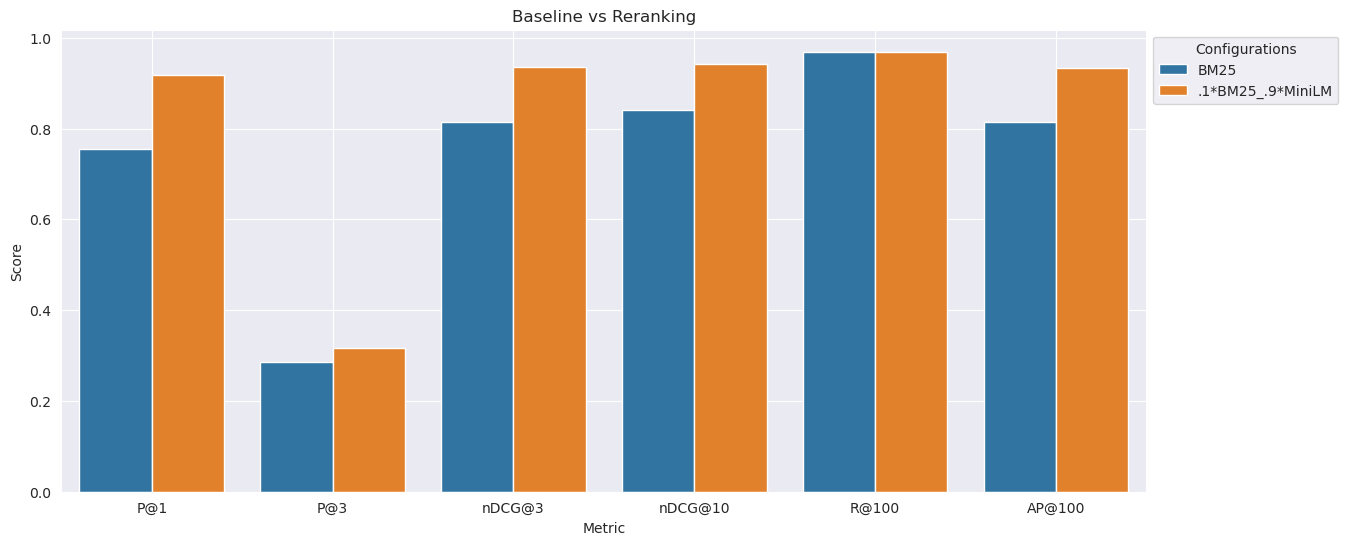

In [35]:
results_plot = results[results['name'].isin(['BM25', '.1*BM25_.9*MiniLM'])].copy()
results_plot = results_plot.reset_index(drop=True)
results_plot = results_plot.drop('mrt', axis=1)

# Melt the DataFrame to long-form for Seaborn
results_melted = results_plot.melt('name', var_name='Metric', value_name='Score')

# Plot the data
plt.figure(figsize=(14, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='name')

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Baseline vs Reranking')
plt.legend(title='Configurations', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()

- Doing just `bm25 % 100 >> biencoder` gives already very good results
- applying the reranker doesn't increase too much the computation time wrt applying only BM25
- when combining the biencoder score with the bm25 score we get a bit higher result than just the biencoder alone

Best pipeline : `bm25 % 100 >> .1*norm_bm25 + .9*norm_bi_enc`